<a href="https://colab.research.google.com/github/vipul43/image_description/blob/main/image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installs

In [2]:
# imports
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pylab as plt
import pickle
from skimage import transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer
import spacy
import nltk
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import re

In [3]:
nltk.download('punkt') #tokenizer
nltk.download('wordnet') #lemmatization

lemmatizer = WordNetLemmatizer() #lemmatizer

sp = spacy.load('en_core_web_sm') #lexical importance find

ls = LancasterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# data loading
!gdown --id 1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm #PASCAL50S

mat = scipy.io.loadmat('/content/pascal50S.mat')

Downloading...
From: https://drive.google.com/uc?id=1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm
To: /content/pascal50S.mat
100% 1.12M/1.12M [00:00<00:00, 75.2MB/s]


In [5]:
#creating tokenizer on the dataset
stringX2 = []
# stop_words = ["a", "the", "is", "be", "will"]
stop_words=['the', 'a', 'and', 'is', 'be', 'will']

for sample in mat["train_sent_final"][0]:
  for k in sample[1]:
    for sent in k:
      new_sent = "<start> "
      sentence = re.sub(r'[^\w\s]','',sent[0])
      sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
      for word in sentence.split():
        pre_word = lemmatizer.lemmatize(word.lower())
        new_sent+=pre_word+" "
      new_sent+="<end>"
      stringX2.append(new_sent)

tk = Tokenizer(filters='')
tk.fit_on_texts(stringX2)
print(len(tk.word_index))

6801


In [6]:
#preprocessing data
data = []
stop_words=['the', 'a', 'and', 'is', 'be', 'will']
for sample in mat["train_sent_final"][0]:
  link = sample[0][0]
  i=0
  for sent in sample[1][0]:
    i+=1
    new_sent = "<start> "
    sentence = re.sub(r'[^\w\s]','',sent[0])
    sentence = ' '.join([word for word in sentence.split() if word not in stop_words])  #removing stop words
    for word in sentence.split():
      pre_word = lemmatizer.lemmatize(word.lower())
      new_sent+=pre_word+" "
    new_sent+="<end>"
    data.append([link, new_sent])
    if(i==10):
      break
print(len(data))
print(data[:10])

10000
[['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> man in boat fishing <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> man fishing out of canoe <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a lone fisherman in rowboat on an empty lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a person fishing in boat on lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fishing in river <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fishing in canoe on lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man fish in canoe in an empty lake <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a man in canoe fishing <end>'], ['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg', '<start> a person in canoe fish on lake <end>

#**Model**

In [49]:
# model making(Image to Vector)
# input layer
input1 = tf.keras.Input(shape=(224, 224, 3), name='input1')

# Transfer Learning with VGG16 model with weights as imagenet
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", classes=20)
vgg16.trainable = False
x = vgg16(input1)

# Dense Layers
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.BatchNormalization(name='norm1')(x)
x = tf.keras.layers.Dense(192, activation='relu', name='dense1')(x)
x = tf.keras.layers.BatchNormalization(name='norm2')(x)
x = tf.keras.layers.Dense(84, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='norm3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense3')(x)
x = tf.keras.layers.BatchNormalization(name='norm4')(x)

#Output layer
output = tf.keras.layers.Dense(500, activation="linear", name='output')(x)

model1 = tf.keras.models.Model(inputs=input1, outputs=output, name='model1')

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 25088)             100352    
_________________________________________________________________
dense1 (Dense)               (None, 192)               4817088   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 192)               768       
_________________________________________________________________
dense2 (Dense)               (None, 84)                16212

In [61]:
# functions to enable the task

def get_coefs(word, *arr): 
  return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix(embed_path, embed_dim, tokenizer, vocab_len):
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embed_path, errors='ignore'))
  embedding_matrix = np.zeros((vocab_len + 1, embed_dim))
  for word, index in tokenizer.word_index.items():
    if index > vocab_len:
      break
    else:
      try:
          embedding_matrix[index] = embeddings_index[word]
      except:
          continue
  return embedding_matrix


In [62]:
!gdown --id 1C4EF6dN5sE28XFm7CefcWBgzRwfF90Pz
!unzip /content/glove.42B.300d.zip &> /dev/null
!rm -rf /content/glove.42B.300d.zip &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1C4EF6dN5sE28XFm7CefcWBgzRwfF90Pz
To: /content/glove.42B.300d.zip
1.88GB [00:23, 78.5MB/s]


In [63]:
embed_path = '/content/glove.42B.300d.txt'
EMBED_DIM = 300
EMBEDDING_MATRIX = get_embeddings_matrix(embed_path, EMBED_DIM, tk, len(tk.word_index))
print("Embeddings Matrix shape: ", EMBEDDING_MATRIX.shape)

Embeddings Matrix shape:  (6802, 300)


In [ ]:
INP_LEN1 = 100 #(Text to Vector)
input2 = tf.keras.Input(shape=(INP_LEN1,), name='input')
# embed = tf.keras.layers.Embedding((len(tk.word_counts)+1),INP_LEN1)(input2)
embed = tf.keras.layers.Embedding(len(tk.word_index)+1, EMBED_DIM, weights=[EMBEDDING_MATRIX], trainable=False)(input2)
rnn1 = tf.keras.layers.LSTM(192, return_sequences=True, dropout=0.3)(embed)
pool = tf.keras.layers.MaxPool1D()(rnn1)
rnn2 = tf.keras.layers.LSTM(128, dropout=0.2)(pool)
dense1 = tf.keras.layers.Dense(84, activation='relu')(rnn2)
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
norm1 = tf.keras.layers.BatchNormalization()(drop1)
output = tf.keras.layers.Dense(500, activation='linear')(norm1)

model2 = tf.keras.models.Model(inputs=input2, outputs=output, name='model2')
model2.summary()


**Concatenating the Image Model(Model1) and Text Model(Model2)**

In [ ]:
concate = tf.keras.layers.Concatenate(axis=-1)([model1.output, model2.output])
final_dense = tf.keras.layers.Dense(256, activation='relu')(concate)
Output = tf.keras.layers.Dense(len(tk.word_counts)+1, activation='softmax')(final_dense)
finalModel  = tf.keras.models.Model(inputs=[input1,input2],outputs=Output)

finalModel.summary()
tf.keras.utils.plot_model(finalModel,to_file="finalModel.png")

Model2


In [72]:
#data generator to 

def data_generator(data, tk, new_shape, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for point in data:
      n+=1
      photo = io.imread(point[0])
      photo = transform.resize(image=photo, output_shape=new_shape)
      sent = point[1]
      seq = [tk.word_index[word] for word in sent.split(' ') if word in tk.word_index.keys()]
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=100, padding='post')[0]
        out_seq = to_categorical([out_seq], num_classes=len(tk.word_index)+1)[0]
        X1.append(photo)
        X2.append(in_seq)
        y.append(out_seq)
      if n == batch_size:
        yield ([np.asarray(X1), np.asarray(X2)], np.asarray(y))
        X1, X2, y = list(), list(), list()
        n=0

# predict function
index_word = dict(map(reversed, tk.word_index.items()))
def predict(image, finalModel):
  partial_caption = "<start>"
  for i in range(100):
    seq = [tk.word_index[word] for word in partial_caption.split() if word in tk.word_index.keys()]
    seq = pad_sequences([seq], maxlen=100, padding='post')
    yhat = finalModel.predict([np.expand_dims(image, 0),[seq]], verbose=0)
    yhat = np.argmax(yhat)
    word = index_word[yhat]
    partial_caption += (' ' + word)
    if word == "<end>":
        break
  final_caption = partial_caption.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

##Model1

In [73]:
finalModel.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001), loss='categorical_crossentropy')

In [ ]:
batch_size = 16
generator = data_generator(data,tk, (224, 224, 3), batch_size)
finalModel.fit(generator, epochs=5, shuffle=True)
# batches = (53500/batch_size)

## Model2

In [96]:
# define the captioning model
from keras.layers.merge import add

def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = tf.keras.Input(shape=(224, 224, 3))
	fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
	fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = tf.keras.Input(shape=(max_length,))
	se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = tf.keras.layers.Dropout(0.5)(se1)
	se3 = tf.keras.layers.LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
	outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
	return model



In [97]:
max_length = 100
vocab_size = len(tk.word_counts)
model_g1 = define_model(vocab_size, max_length)


batch_size = 16
generator = data_generator(data,tk, (224, 224, 3), batch_size)
model_g1.fit(generator, epochs=5, shuffle=True)
# batches = (53500/batch_size)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 100, 256)     1741056     input_25[0][0]                   
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 224, 224, 3)  0           input_24[0][0]                   
____________________________________________________________________________________________

ValueError: ignored

In [ ]:
idx = np.random.randint(len(data))
photo = io.imread(data[idx][0])
photo = transform.resize(image=photo, output_shape=(224, 224, 3))
label = data[idx][1]
pred = predict(photo, model_g1)
plt.imshow(photo)
print("original label ", label)
print("predicted label ", pred)

In [82]:
# partial_caption = "<start> the"
# seq = [tk.word_index[word] for word in partial_caption.split() if word in tk.word_index.keys()]
# seq = pad_sequences([seq], maxlen=100)
# yhat = finalModel.predict([np.expand_dims(photo, 0),[seq]], verbose=0)
# yhat = np.argmax(yhat)
# word = index_word[yhat]
# word

tk.word_index['a']

3

original label  <start> a group of people posing for photo while eating dinner in living room <end>
predicted label  a a


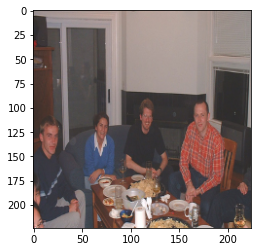

In [83]:
idx = np.random.randint(len(data))
photo = io.imread(data[idx][0])
photo = transform.resize(image=photo, output_shape=(224, 224, 3))
label = data[idx][1]
pred = predict(photo, finalModel)
plt.imshow(photo)
print("original label ", label)
print("predicted label ", pred)

In [78]:
pred

'a a'

In [ ]:
# plotting curves
'''
loss -> train, val
accuracy -> train, val
'''
plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[2])
plt.title('Loss Plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(list(history.history.values())[1])
plt.plot(list(history.history.values())[3])
plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()